# Oscillator Strengths with Modified ARC
*Monika Schleier-Smith (January, 2021), building on prior work by Ognjen Markovic*

In [1]:
# Configure the matplotlib graphics library and configure it to show 

# show figures inline in the notebook
import matplotlib
%matplotlib inline
#matplotlib notebook
import matplotlib.pyplot as plt  # Import library for direct plotting functions
import numpy as np               # Import Numerical Python
from IPython.core.display import display, HTML #Import HTML for formatting output
from scipy.optimize import curve_fit
from numpy.polynomial import polynomial as poly

# NOTE: Uncomment following lines ONLY if you are not using installation via pip
#import sys, os
#rootDir = '/Dropbox/Research/Calculations/ARC/ARC-Alkali-Rydberg-Calculator-2.0.5' # e.g. '/Users/Username/Desktop/ARC-Alkali-Rydberg-Calculator'
#sys.path.insert(0,rootDir)

#matplotlib.__version__

from arc import *                 #Import ARC (Alkali Rydberg Calculator)

## About This Notebook ##

This notebook tests a modified version of ARC in which I introduced two new parameters to the *getRadialMatrixElement* function:
* *corePolRc* is the cutoff radius (in atomic units) for the correction to the radial matrix element in Eq. 19 of Marinescu et al., where it is called $r_c'$
* *rmin* is the lower bound of integration (in atomic units) for calculating the radial matrix element.  The default value (which is set by the cube root of the polarizability) is too large, as Ogi noticed in his previous calculations

A copy of the modified *getRadialMatrixElement* function is included at the end of this file for completeness (but I directly modified it in my version of ARC).

### Notes on the modified *getRadialMatrixElement* function:###
* Setting $r_c' = 0$, or not specifying $r_c'$ at all, makes the function ignore the core polarizability effect just as it usually would
* Ordinarily the *getRadialMatrixElement* function is clever about not recalculating matrix elements that have already previously been calculated.  However, I treat $r_c' \neq 0$ as a special case for which this functionality is ignored.  So if a nonzero value of $r_c'$ is specified, the matrix element is always recalculated; and if the matrix element has previously been calculated with $r_c' \neq 0$ it will be recalculated in a subsequent call with $r_c' = 0$.
* For the modification of *getRadialMatrixElement* to propagate all the way to ARC's calculation of Rabi frequencies, one would need to:
    * ***Either*** modify a whole sequence of other functions: *getReducedMatrixElement*, *getDipoleMatrixElement*, *getRabiFrequency2*, and *getRabiFrequency* to include optional arguments *corePolRc* and *rmin*
    * ***Or*** include *corePolRc* in the *alkali_atom_data* function that defines the properties of cesium (which already includes the model potential parameters from Marinescu) and change how *getRadialMatrixElement* sets *rmin*
* Note that *corePolRc* (which I also sometimes call *rc* within this notebook) is called $r_c'$ in Marinescu et al., and is *not* the same as the $r_c$ that is tabulated in Marinescu and included in *alkali_atom_data* to parameterize the core potential.
* Also, as the analysis below will show, whereas Marinescu gives a value $r_c' = 4.916\dots$ to empirically fit polarizability data, we find here that fitting oscillator strength values from the literature requires a value $r_c' = 3.41(1)$.

### References ###
* M. Marinescu, H. R. Sadeghpour, and A. Dalgarno, *PRA* **49**, 982 (1994), https://doi.org/10.1103/PhysRevA.49.982
* J. Migdalek and Y.-K. Kim, *J. Phys. B* **31**, 1947 (1998), https://doi-org.stanford.idm.oclc.org/10.1088/0953-4075/31/9/011
* J. M. Raimond, M. Gross, C. Fabre, S. Haroche, and H H Stroke, *J. Phys. B* **11**, L765 (1978), https://doi-org.stanford.idm.oclc.org/10.1088/0022-3700/11/24/004
* G. Pichler, *Journal of Quantitative Spectroscopy and Radiative Transfer* **16**, 147 https://doi.org/10.1016/0022-4073(76)90096-0
* A. M. Hankin, Y.-Y. Jau, L. P. Parazzoli, C. W. Chou, D. J. Armstrong, A. J. Landahl, and G. W. Biedermann, *PRA* **89**, 033416 (2014), https://doi-org.stanford.idm.oclc.org/10.1103/PhysRevA.89.033416

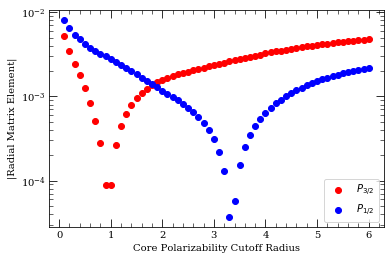

In [2]:
atom = Caesium()

rcvals = np.linspace(0.1,6,60)
rmin = 0.05
rmeP32 = [abs(atom.getRadialMatrixElement(6,0,0.5,43,1,1.5,corePolRc=rc,rmin=rmin)) for rc in rcvals]
rmeP12 = [abs(atom.getRadialMatrixElement(6,0,0.5,43,1,0.5,corePolRc=rc,rmin=rmin)) for rc in rcvals]

plt.figure()
plt.plot(rcvals,rmeP32,'ro',label=r"$P_{3/2}$")
plt.plot(rcvals,rmeP12,'bo',label=r"$P_{1/2}$")
#plt.plot(rcvals,rmeP32b,label=r"$P_{3/2}$")
#plt.plot(rcvals,rmeP12b,label=r"$P_{1/2}$")
plt.yscale("log")
plt.ylabel("|Radial Matrix Element|")
plt.xlabel("Core Polarizability Cutoff Radius")
plt.legend()

In [3]:
def osc_strength(n,l,j,npp,lp,jp,rc=3.43,rmin=0.05,verbose=False):
    rme = atom.getRadialMatrixElement(n,l,j,npp,lp,jp,corePolRc=rc,rmin=rmin)
    Wlower = atom.getEnergy(n,l,j)/(2*atom.scaledRydbergConstant)
    Wupper = atom.getEnergy(npp,lp,jp)/(2*atom.scaledRydbergConstant)
    return (rme**2)*(2*jp+1)/(2*j+1)*2.0/9.0*(Wupper-Wlower)

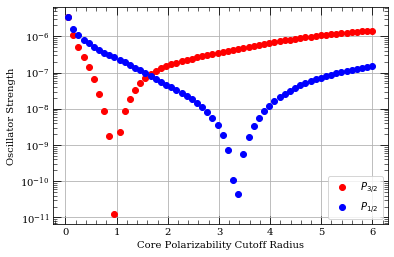

In [4]:
rcvals = np.linspace(0.05,6,60)
rmin = 0.05
oscP32 = [osc_strength(6,0,0.5,43,1,1.5,rc=rc,rmin=rmin) for rc in rcvals]
oscP12 = [osc_strength(6,0,0.5,43,1,0.5,rc=rc,rmin=rmin) for rc in rcvals]

plt.figure()
plt.plot(rcvals,oscP32,'ro',label=r"$P_{3/2}$")
plt.plot(rcvals,oscP12,'bo',label=r"$P_{1/2}$")
plt.yscale("log")
plt.ylabel("Oscillator Strength")
plt.xlabel("Core Polarizability Cutoff Radius")
plt.legend()
plt.grid()

In [5]:
oscratios=np.genfromtxt("cs_osc_strength_ratios.csv",delimiter=',')
# From table in Migdalek & Kim, J. Phys. B: At. Mol. Opt. Phys. 31 (1998) 1947–1960,
# referring to Pichler (1976) and Raimond (1978).
# print(oscratios[:,0:2])

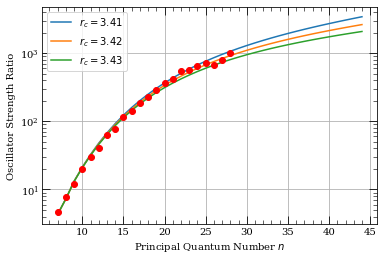

In [6]:
nvals = np.arange(7,45,1)

rc = 3.41
osc_strength_ratio341 = [osc_strength(6,0,0.5,n,1,1.5,rc=rc,rmin=0.05)/osc_strength(6,0,0.5,n,1,0.5,rc=rc,rmin=0.05) for n in nvals]
rc = 3.43
osc_strength_ratio343 = [osc_strength(6,0,0.5,n,1,1.5,rc=rc,rmin=0.05)/osc_strength(6,0,0.5,n,1,0.5,rc=rc,rmin=0.05) for n in nvals]
rc = 3.42
osc_strength_ratio342 = [osc_strength(6,0,0.5,n,1,1.5,rc=rc,rmin=0.05)/osc_strength(6,0,0.5,n,1,0.5,rc=rc,rmin=0.05) for n in nvals]


plt.figure()
plt.semilogy(nvals,osc_strength_ratio341,label=r"$r_c = 3.41$")
plt.semilogy(nvals,osc_strength_ratio342,label=r"$r_c = 3.42$")
plt.semilogy(nvals,osc_strength_ratio343,label=r"$r_c = 3.43$")
plt.semilogy(oscratios[:,0],oscratios[:,1],'ro')
plt.ylabel("Oscillator Strength Ratio")
plt.xlabel(r"Principal Quantum Number $n$")
plt.legend()
plt.grid()

Here we see that setting $r_c = 3.41$ gives good agreement with oscillator strengths quoted in the literature at $n=15$ (Pichler) and $n=84$ (Hankin), as well as matching the above curve of oscillator strength ratios reasonably well.

In [7]:
rc=3.41

print(osc_strength(6,0,0.5,15,1,0.5,rc=rc))
print(osc_strength(6,0,0.5,15,1,1.5,rc=rc))
# Pichler: 2.1e-7, 2.4e-5

2.013590371769097e-07
2.4735537354564195e-05


In [8]:
print(osc_strength(6,0,0.5,84,1,0.5,rc=rc))
print(osc_strength(6,0,0.5,84,1,1.5,rc=rc))
# Hankin: 2e-12, 6e-8

1.996823211768531e-12
5.278752908059023e-08


In [9]:
print(osc_strength(7,1,1.5,43,2,1.5,rc=0))
print(osc_strength(7,1,1.5,43,2,1.5,rc=rc))

5.5320011778372784e-05
5.595106815518477e-05


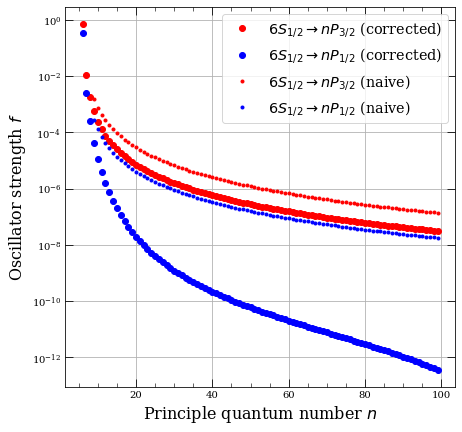

In [27]:
nvals2=range(6,100)

f3h = [osc_strength(6,0,0.5,n,1,1.5,rc=3.41) for n in nvals2]
f1h = [osc_strength(6,0,0.5,n,1,0.5,rc=3.41) for n in nvals2]

f3h_naive = [osc_strength(6,0,0.5,n,1,1.5,rc=0) for n in nvals2]
f1h_naive = [osc_strength(6,0,0.5,n,1,0.5,rc=0) for n in nvals2]

correction_factor_3 = [f3h[j]/f3h_naive[j] for j in range(len(f3h))]
correction_factor_1 = [f1h[j]/f1h_naive[j] for j in range(len(f1h))]

plt.figure(figsize=(7,7))

plt.semilogy(nvals2,f3h,'ro',label=r'$6S_{1/2}\rightarrow nP_{3/2}$ (corrected)')
plt.semilogy(nvals2,f1h,'bo',label=r'$6S_{1/2}\rightarrow nP_{1/2}$ (corrected)')

plt.semilogy(nvals2,f3h_naive,'r.',label=r'$6S_{1/2}\rightarrow nP_{3/2}$ (naive)')
plt.semilogy(nvals2,f1h_naive,'b.',label=r'$6S_{1/2}\rightarrow nP_{1/2}$ (naive)')

plt.xlabel('Principle quantum number $n$',size=16)
plt.ylabel("Oscillator strength $f$",size=16)
plt.legend(fontsize='x-large')
plt.grid()

plt.savefig("Cs_oscillator_strengths.pdf")
plt.savefig("Cs_oscillator_strengths.png")

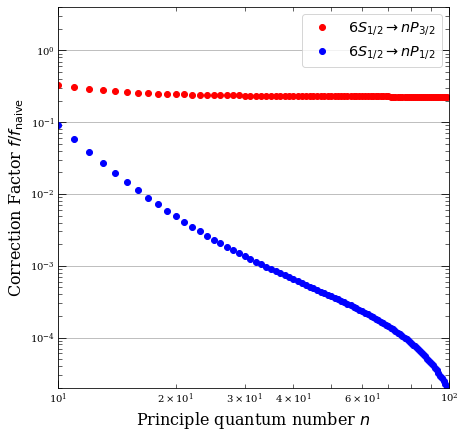

In [29]:
### Plot the ratio of corrected oscillator strength (accounting for core polarizability)
### to naive oscillator strength (as ordinarily implemented in ARC)

plt.figure(figsize=(7,7))
plt.loglog(nvals2,correction_factor_3,'ro',label=r'$6S_{1/2}\rightarrow nP_{3/2}$')
plt.loglog(nvals2,correction_factor_1,'bo',label=r'$6S_{1/2}\rightarrow nP_{1/2}$')
plt.ylabel("Correction Factor $f/f_\mathrm{naive}$",size=16)
plt.xlabel('Principle quantum number $n$',size=16)
plt.ylim(bottom=2e-5, top=4e0)
plt.xlim(left=1e1,right=1e2)
plt.legend(fontsize='x-large')
plt.grid()

#print(osc_strength(6,0,0.5,50,1,1.5,rc=3.41)/osc_strength(6,0,0.5,50,1,1.5,rc=0))
#print(osc_strength(6,0,0.5,100,1,1.5,rc=3.41)/osc_strength(6,0,0.5,100,1,1.5,rc=0))

plt.savefig("Cs_oscillator_strength_correction.png")

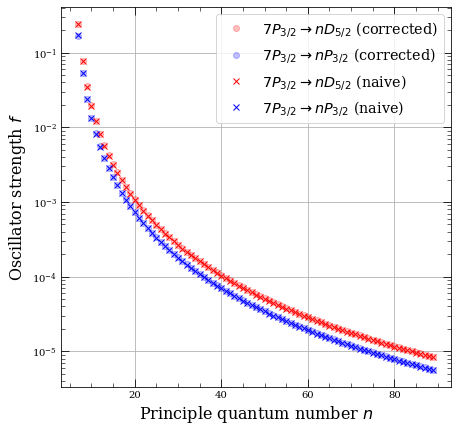

In [81]:
### For 7P_{3/2} -> nD transitions, the effect of core polarizability is negligible (as expected)

nvals2=range(7,90)

fPD52 = [osc_strength(7,1,1.5,n,2,2.5,rc=3.41) for n in nvals2]
fPD32 = [osc_strength(7,1,1.5,n,2,1.5,rc=3.41) for n in nvals2]

fPD52_naive = [osc_strength(7,1,1.5,n,2,2.5,rc=0) for n in nvals2]
fPD32_naive = [osc_strength(7,1,1.5,n,2,1.5,rc=0) for n in nvals2]


plt.figure(figsize=(7,7))

plt.semilogy(nvals2,fPD52,'ro',alpha=0.25,label=r'$7P_{3/2}\rightarrow nD_{5/2}$ (corrected)')
plt.semilogy(nvals2,fPD32,'bo',alpha=0.25,label=r'$7P_{3/2}\rightarrow nP_{3/2}$ (corrected)')

plt.semilogy(nvals2,fPD52_naive,'rx',label=r'$7P_{3/2}\rightarrow nD_{5/2}$ (naive)')
plt.semilogy(nvals2,fPD32_naive,'bx',label=r'$7P_{3/2}\rightarrow nP_{3/2}$ (naive)')

plt.xlabel('Principle quantum number $n$',size=16)
plt.ylabel("Oscillator strength $f$",size=16)
plt.legend(fontsize='x-large')
plt.grid()

plt.savefig("Cs_oscillator_strengths_7PnD.pdf")
plt.savefig("Cs_oscillator_strengths_7PnD.png")

# Modified *getRadialMatrixElement* Function for Reference

In [36]:
### This is not really intended to be run in this notebook...just copied here for information.
### Though I suppose one could alternatively redefine the function directly in the notebook

def getRadialMatrixElement(self,n1,l1,j1,n2,l2,j2,useLiterature=True,corePolRc=0.0,rmin=0.05,verbose=False):
        """
            Radial part of the dipole matrix element

            Calculates :math:`\\int \\mathbf{d}r~R_{n_1,l_1,j_1}(r)\cdot \
                R_{n_1,l_1,j_1}(r) \cdot r^3`.

            Args:
                n1 (int): principal quantum number of state 1
                l1 (int): orbital angular momentum of state 1
                j1 (float): total angular momentum of state 1
                n2 (int): principal quantum number of state 2
                l2 (int): orbital angular momentum of state 2
                j2 (float): total angular momentum of state 2

            Returns:
                float: dipole matrix element (:math:`a_0 e`).

            Verbose option and corePolRc added by MSS
        """
        dl = abs(l1-l2)
        dj = abs(j2-j2)
        if not(dl==1 and (dj<1.1)):
            return 0

        if (self.getEnergy(n1, l1, j1)>self.getEnergy(n2, l2, j2)):
            temp = n1
            n1 = n2
            n2 = temp
            temp = l1
            l1 = l2
            l2 = temp
            temp = j1
            j1 = j2
            j2 = temp

        n1 = int(n1)
        n2 = int(n2)
        l1 = int(l1)
        l2 = int(l2)
        j1_x2 = int(round(2*j1))
        j2_x2 = int(round(2*j2))

        if useLiterature:
            # is there literature value for this DME? If there is, use the best one (smalles error)
            self.c.execute('''SELECT dme FROM literatureDME WHERE
             n1= ? AND l1 = ? AND j1_x2 = ? AND
             n2 = ? AND l2 = ? AND j2_x2 = ?
             ORDER BY errorEstimate ASC''',(n1,l1,j1_x2,n2,l2,j2_x2))
            answer = self.c.fetchone()
            if (answer):
                # we did found literature value
                if verbose: ##verbose option added by MSS
                    print("Using Literature Value:", answer[0])
                return answer[0]


        # was this calculated before? If it was, retrieve from memory
        self.c.execute('''SELECT dme FROM dipoleME WHERE
         n1= ? AND l1 = ? AND j1_x2 = ? AND
         n2 = ? AND l2 = ? AND j2_x2 = ?''',(n1,l1,j1_x2,n2,l2,j2_x2))
        dme = self.c.fetchone()
        if (dme and corePolRc==0.0):
            if verbose:
                print("Using previously calculated value:", dme[0])
            return dme[0]

        step = 0.001
        r1,psi1_r1 = self.radialWavefunction(l1,0.5,j1,\
                                               self.getEnergy(n1, l1, j1)/27.211,\
                                               self.alphaC**(1/3.0),\
                                                2.0*n1*(n1+15.0), step)
        r2,psi2_r2 = self.radialWavefunction(l2,0.5,j2,\
                                               self.getEnergy(n2, l2, j2)/27.211,\
                                               self.alphaC**(1/3.0),\
                                                2.0*n2*(n2+15.0), step)

        upTo = min(len(r1),len(r2))

        #############################
        #############################
        ## Code block added by MSS ##

        if corePolRc != 0.0:
            if verbose:
                print("alphaC:", self.alphaC)

            #### Added because Ogi found that the default lower limit of integration is too high
            rmin = min(rmin,self.alphaC**(1/3.0)) ### default (presumably from Marinescu?)
            r1,psi1_r1 = self.radialWavefunction(l1,0.5,j1,\
                                               self.getEnergy(n1, l1, j1)/27.211,\
                                               rmin,\
                                                2.0*n1*(n1+15.0), step)
            r2,psi2_r2 = self.radialWavefunction(l2,0.5,j2,\
                                               self.getEnergy(n2, l2, j2)/27.211,\
                                               rmin,\
                                                2.0*n2*(n2+15.0), step)

            upTo = min(len(r1),len(r2))
            #####################################################################################

            rmod = [r*(1-(1-np.exp(-(r/corePolRc)**3))*self.alphaC/r**3) for r in r1]
            dipoleElement = np.trapz(np.multiply(np.multiply(psi1_r1[0:upTo],psi2_r2[0:upTo]),\
                                           rmod[0:upTo]), x = r1[0:upTo])
            return dipoleElement


        #############################
        #############################

        # note that r1 and r2 change in same staps, starting from the same value
        dipoleElement = np.trapz(np.multiply(np.multiply(psi1_r1[0:upTo],psi2_r2[0:upTo]),\
                                           r1[0:upTo]), x = r1[0:upTo])

        self.c.execute(''' INSERT INTO dipoleME VALUES (?,?,?, ?,?,?, ?)''',\
                       [n1,l1,j1_x2,n2,l2,j2_x2, dipoleElement] )
        self.conn.commit()

        return dipoleElement
